#Outbrain Click Prediction 
The purpose of the Outbrain competition is to predict which recommended content each user will click. Outbrain has provided various relational datasets that need to be explored before any modeling can begin. 

###Import Libraries

###Raw Data 

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import sys
import sqlite3 as sql
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline

print('Files To Explore:')
for f in os.listdir('inputs/'):
    if 'csv' in f:
        print(f.ljust(30) + str(round(os.path.getsize('inputs/' + f)/1000000.0, 2)) + " MB")

Files To Explore:
clicks_test.csv               506.95 MB
clicks_train.csv              1486.73 MB
documents_categories.csv      118.02 MB
documents_entities.csv        324.1 MB
documents_meta.csv            89.38 MB
documents_topics.csv          339.47 MB
events.csv                    1208.55 MB
page_views_sample.csv         454.35 MB
promoted_content.csv          13.89 MB
sample_submission.csv         273.14 MB


####What are the dimensions of each dataset?

In [35]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

print('File Dimensions:')
for f in os.listdir('inputs/'):
    if 'csv' in f:
        rows=file_len('inputs/'+f)
        doc=pd.read_csv('inputs/'+f, nrows=1)
        print(f.ljust(30) + '('+str(rows)+','+str(len(doc.columns))+')')
        


File Dimensions:
clicks_test.csv               (32225163,2)
clicks_train.csv              (87141732,3)
documents_categories.csv      (5481476,3)
documents_entities.csv        (5537553,3)
documents_meta.csv            (2999335,4)
documents_topics.csv          (11325961,3)
events.csv                    (23120127,6)
page_views_sample.csv         (10000000,6)
promoted_content.csv          (559584,4)
sample_submission.csv         (6245534,2)


 ####Are there any common variables?

In [42]:
print('File Column Names:')
for f in os.listdir('inputs/'):
    if 'csv' in f:
        doc=pd.read_csv('inputs/'+f, nrows=1)
        print(f.ljust(30) + str(list(doc.columns.values)))
        

File Columns:
clicks_test.csv               ['display_id', 'ad_id']
clicks_train.csv              ['display_id', 'ad_id', 'clicked']
documents_categories.csv      ['document_id', 'category_id', 'confidence_level']
documents_entities.csv        ['document_id', 'entity_id', 'confidence_level']
documents_meta.csv            ['document_id', 'source_id', 'publisher_id', 'publish_time']
documents_topics.csv          ['document_id', 'topic_id', 'confidence_level']
events.csv                    ['display_id', 'uuid', 'document_id', 'timestamp', 'platform', 'geo_location']
page_views_sample.csv         ['uuid', 'document_id', 'timestamp', 'platform', 'geo_location', 'traffic_source']
promoted_content.csv          ['ad_id', 'document_id', 'campaign_id', 'advertiser_id']
sample_submission.csv         ['display_id', 'ad_id']


Based on the investigation below, I think the next steps are to merge **clicks_train** with **events** on *display_id*. From here we will have information on a particular user, *uuid* and the corresponding *ad_id* they clicked. We also have the corresponding *document_id*. (Just to make sure there isn't any weird merging going on, I would check that the *ad_id* to *document_id* xwlk that emerges from that new dataset matches what we find in the **promoted_content** dataset.) 

Once this dataset looks clean, we can merge on the document related information -- **documents_meta**, **documents_entities**, **documents_topics**, etc.).

The big question is still how to incorporate **page_views** dataset??


###Review *Page View* Sample

**Page_views** gives us a log of all the users that visited each website within the recorded timeframe, 14-June-2016 to 28-June-2016.


In [4]:
pg_views=pd.read_csv('inputs/page_views_sample.csv')

In [49]:
pg_views.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2


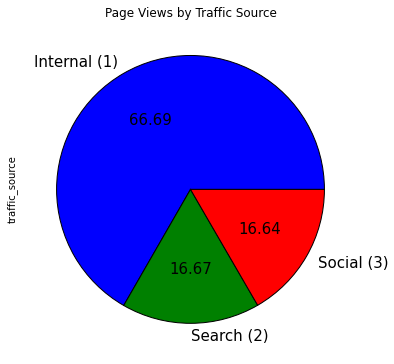

In [17]:
pg_view_by_traffic_source=pg_views.traffic_source.value_counts()
pg_view_by_traffic_source
pg_view_by_traffic_source.plot.pie(y='count', figsize=(6, 6), labels=['Internal (1)', 'Search (2)', 'Social (3)'], 
              title='Page Views by Traffic Source', autopct='%.2f', fontsize=15)

In [18]:
%time promoted_content=pd.read_csv('inputs/promoted_content.csv')

CPU times: user 260 ms, sys: 70.6 ms, total: 330 ms
Wall time: 334 ms


In [41]:
promoted_content=promoted_content.sort_values(['document_id'])
promoted_content.head()


,ad_id,document_id,campaign_id,advertiser_id
369245,371657,1,6050,1531
369336,371749,1,6051,1531
276883,278853,1305,1960,45
467810,470614,1418,16993,1310
497766,500762,1443,16993,1310


###Review *Clicks* Data

In [65]:
train=pd.read_csv('inputs/clicks_train.csv')
print('Train Shape:' + str(train.shape))
train.head(25)

Train Shape:(87141731, 3)


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0
5,1,296965,0
6,2,125211,0
7,2,156535,0
8,2,169564,0
9,2,308455,1


In [78]:
print('Test Shape:'+str(test.shape))
test.head()

Test Shape:(32225162, 2)


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888


###Review *Documents* Data

In [43]:
doc_cat=pd.read_csv('inputs/documents_categories.csv')
doc_ent=pd.read_csv('inputs/documents_entities.csv')
doc_meta=pd.read_csv('inputs/documents_topics.csv')

In [44]:
doc_cat.sort_values(['document_id']).head()

,document_id,category_id,confidence_level
2352305,1,1706,0.471220
2352306,1,1603,0.035854
366940,2,1705,0.600000
366941,2,1708,0.400000
52239,3,2003,0.522837


In [56]:
doc_ent.sort_values(['document_id']).head()

,document_id,entity_id,confidence_level
2397974,1,f065e2b0f640b2ffa1f5f8cbf110dcbf,0.481631
502355,2,e88e4cde6c6482ff01d4ad424904ffd1,0.653912
502356,2,a10e6138ae70ab0054246d4a6b1bb5ac,0.539136
72833,3,7f77b6d24f62a1ad1b469fdf4bc0a7f4,0.320940
2626850,4,edd8b2032ce96ab2bbe6cf8aca90727b,0.744933


In [57]:
doc_meta.sort_values(['document_id']).head()

,document_id,topic_id,confidence_level
4504009,1,137,0.009344
4504008,1,276,0.010160
4504007,1,150,0.011959
4504006,1,35,0.012773
4504005,1,252,0.020726


###Review *Events* Data

**Events** data provides information on the *display_id* variable. Investigations below suggest that *display_id* is unique in the **events** dataset.

In [64]:
events=pd.read_csv('inputs/events.csv')


In [66]:
events.sort_values(['display_id']).head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [68]:
events.display_id.value_counts().sort_values()

20977661    1
20994037    1
16801780    1
12609523    1
8417266     1
8450018     1
4225009     1
21010413    1
16818156    1
16376       1
12625899    1
4241385     1
49128       1
21026789    1
16834532    1
32752       1
8630154     1
16900036    1
8515522     1
8433642     1
12773283    1
4208633     1
12593147    1
4274137     1
81880       1
21059541    1
16867284    1
65504       1
12675027    1
4290513     1
           ..
4261921     1
65568       1
8474666     1
12818547    1
17014900    1
21047333    1
16883764    1
21080117    1
21030941    1
21014549    1
16818196    1
12621843    1
8425490     1
4229137     1
32784       1
8441882     1
20998157    1
12605451    1
8409098     1
4212745     1
16392       1
20981765    1
16785412    1
12589059    1
8392706     1
16801804    1
4311097     1
12638235    1
967128      1
4196353     1
Name: display_id, dtype: int64

In [63]:
try:del doc_cat
except:pass;gc.collect()
